<a href="https://colab.research.google.com/github/AlinaOtr/data/blob/master/ab_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ECommerce компания решила сменить поисковый движок на сайте и выбрала одного из новых подрядчиков для теста. Трафик был распределен 50/50: первой группе показывался старый движок, а второй группе новой. Критерием выбора движка для компании являлся статистически значимый прирост выручки - больший, чем стоимость лицензии (100 000 рублей).

Ссылка на файл с данными: https://drive.google.com/file/d/1a47P9TMhJhTYhnRvd9v7f2s5ucWBdpha/view?usp=sharing

In [1]:
!gdown --id 1a47P9TMhJhTYhnRvd9v7f2s5ucWBdpha

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1a47P9TMhJhTYhnRvd9v7f2s5ucWBdpha
To: /content/ab_result-220252-c014c6.csv
100% 18.7M/18.7M [00:00<00:00, 39.6MB/s]


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as stats

In [3]:
df = pd.read_csv('/content/ab_result-220252-c014c6.csv', dtype={'session_id': str, 'clientId': str})
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')

In [4]:
df.head()

,date,clientId,sessionId,experimentVariant,transactionId,transactionRevenue,itemQuantity
0,2021-09-12,941690875.1630132824,1630133172418.188lgetf,0,NaN,NaN,NaN
1,2021-09-03,2123291717.1630582051,1630582225576.6rat3vw,0,NaN,NaN,NaN
2,2021-09-03,1980967937.1629795997,1630591180040.rrnkdmbs,0,NaN,NaN,NaN
3,2021-09-03,1598703630.1598263489,1630616613137.lg5wescf,0,NaN,NaN,NaN
4,2021-09-03,320084506.1630616621,1630616660855.ynh87hjs,0,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302462 entries, 0 to 302461
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date                302462 non-null  datetime64[ns]
 1   clientId            302462 non-null  object        
 2   sessionId           302462 non-null  object        
 3   experimentVariant   302462 non-null  int64         
 4   transactionId       29999 non-null   object        
 5   transactionRevenue  29999 non-null   float64       
 6   itemQuantity        29999 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 16.2+ MB


In [6]:
df.date.min()

Timestamp('2021-09-03 00:00:00')

In [7]:
df.date.max()

Timestamp('2021-10-25 00:00:00')

Тест длился 7 полных недель и 4 дня. За это время мы набрали 302 462 посещения сайта. Из них 29 999 значений выручки не null. Лучше, когда тест проводится ровное количество недель, так как покупки товаров могут зависеть от дня недели. Если у нас были бы исторические данные, можно было бы посмотреть, какая у нас была ранее выручка за месяц, и посчитать необходимое количество данных для проведения теста. Если нужное количество набирается за 7 недель, то сократить выборку. А если нет, то по возможности продлить эксперимент до 8 недель. За период проведения теста будем считать, что стоимость лицензии = 100 000 * (1 + 23/31) = 174 193 руб.

In [8]:
df.duplicated().sum()

0

In [9]:
df.dropna().transactionId.duplicated().sum()

0

Дубликатов в данных нет

In [10]:
df_old = df[ df['experimentVariant'] == 0]
df_new = df[ df['experimentVariant'] == 1]

In [11]:
df_old[['transactionRevenue', 'itemQuantity']].describe()

,transactionRevenue,itemQuantity
count,14898.000000,14898.000000
mean,1881.265754,6.274936
std,2181.991193,12.040075
min,35.000000,0.000000
25%,683.000000,1.000000
50%,1304.450000,2.000000
75%,2237.000000,6.000000
max,70996.800000,246.000000


In [12]:
df_new[['transactionRevenue', 'itemQuantity']].describe()

,transactionRevenue,itemQuantity
count,15101.000000,15101.000000
mean,1868.204033,6.116350
std,2014.430302,10.959729
min,49.000000,0.000000
25%,675.000000,1.000000
50%,1295.000000,2.000000
75%,2240.000000,6.000000
max,46141.000000,180.000000


Выкину выбросы (1% сверху и снизу)

In [13]:
percentile_99_old = np.percentile(df_old['transactionRevenue'].dropna(), 99)
percentile_99_new = np.percentile(df_new['transactionRevenue'].dropna(), 99)
percentile_1_old = np.percentile(df_old['transactionRevenue'].dropna(), 1)
percentile_1_new = np.percentile(df_new['transactionRevenue'].dropna(), 1)

In [14]:
df_old = df_old[ df_old['transactionRevenue'] < percentile_99_old]
df_old = df_old[ df_old['transactionRevenue'] > percentile_1_old]

In [15]:
df_new = df_new[ df_new['transactionRevenue'] < percentile_99_new]
df_new = df_new[ df_new['transactionRevenue'] > percentile_1_new]

In [16]:
df_old[['transactionRevenue', 'itemQuantity']].describe()

,transactionRevenue,itemQuantity
count,14599.000000,14599.000000
mean,1770.135701,6.111994
std,1537.939746,11.110826
min,149.000000,0.000000
25%,692.000000,1.000000
50%,1304.700000,2.000000
75%,2216.000000,6.000000
max,9328.000000,228.000000


In [17]:
df_new[['transactionRevenue', 'itemQuantity']].describe()

,transactionRevenue,itemQuantity
count,14797.000000,14797.000000
mean,1765.512536,6.024667
std,1536.535474,10.610290
min,147.000000,0.000000
25%,680.200000,1.000000
50%,1295.000000,2.000000
75%,2215.900000,6.000000
max,9375.000000,180.000000


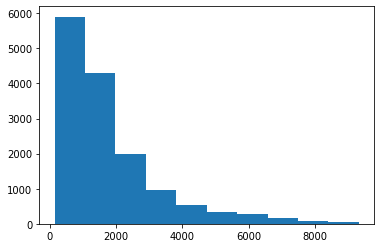

In [18]:
plt.hist(df_old['transactionRevenue'])
plt.show()

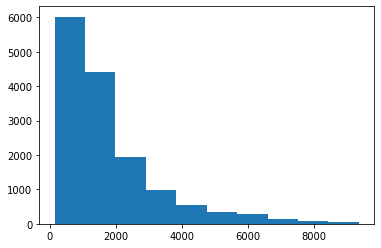

In [19]:
plt.hist(df_new['transactionRevenue'])
plt.show()

Видно, что распределения не являются нормальными. Применим тест Манна-Уитни для проверки гипотезы

In [20]:
mw_test = stats.mannwhitneyu(df_old['transactionRevenue'], df_new['transactionRevenue'])
mw_test

MannwhitneyuResult(statistic=108316583.5, pvalue=0.6741356692953304)

In [21]:
alpha = 0.05
if mw_test.pvalue < alpha:
    print('Тест подтвердился')
else:
    print('Тест опровергнут')

Тест опровергнут


Поскольку p-значение (0.674) не меньше 0,05, мы не можем отвергнуть нулевую гипотезу (о том, что выручка в тестовой и контрольной группе равны). То есть **у нас нет достаточных доказательств того, что выручка при новом поисковом движке вырастет и к тому же ещё окупит стоимость лицензии**.

Убедимся, что не было каких-то провалов по дням. Для этого построим графики среднего чека по дням в каждой из групп.

In [22]:
group_test_old = df_old.groupby('date').agg({'transactionId': 'count', 'transactionRevenue': 'sum' })
group_test_old = group_test_old.reset_index()
group_test_old = group_test_old.rename(columns ={'transactionId': 'orders'})
group_test_old.head()

,date,orders,transactionRevenue
0,2021-09-03,309,608796.1
1,2021-09-04,261,490945.5
2,2021-09-05,332,589972.8
3,2021-09-06,256,419355.7
4,2021-09-07,292,523417.0


In [23]:
group_test_new = df_new.groupby('date').agg({'transactionId': 'count', 'transactionRevenue': 'sum' })
group_test_new = group_test_new.reset_index()
group_test_new = group_test_new.rename(columns ={'transactionId': 'orders'})
group_test_new.head()

,date,orders,transactionRevenue
0,2021-09-03,311,597103.7
1,2021-09-04,295,521258.9
2,2021-09-05,308,525463.4
3,2021-09-06,270,411604.6
4,2021-09-07,315,636101.4


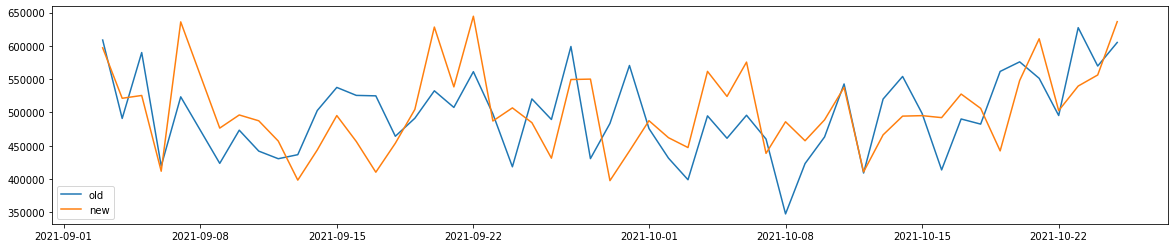

In [24]:
plt.figure(figsize=(20,4))
plt.plot(group_test_old['date'], group_test_old['transactionRevenue'], label = 'old')
plt.plot(group_test_new['date'], group_test_new['transactionRevenue'], label = 'new')
plt.legend()
plt.show()